In [1]:
import pymc as pm
import numpy as np
import arviz as az
from pymc.math import logit, exp
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

np.set_printoptions(suppress=True)

# Cumulative Example*

Adapted from [Unit 9: cumulative2.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/cumulative2.odc).

## Notes

From the OpenBUGS manual:

> cumulative(s1, s2): tail area of distribution of s1 up to the value of s2, s1 must be stochastic, s1 and s2 can be the same


## Fitting the model

As we said on the previous page, we want to evaluate the Empirical CDF at the values of our response variable to check how well our model fits the data. First, we'll fit our model and add posterior predictive samples to the trace.

In [3]:
y = np.array(
    [
        0.0,
        1.0,
        2.0,
        -1.0,
        0.4,
        -0.5,
        0.7,
        -1.2,
        0.1,
        -0.4,
        0.2,
        -0.5,
        -1.4,
        1.8,
        0.2,
        0.3,
        -0.6,
        1.1,
        5.1,
        -6.3,
    ]
)

In [4]:
with pm.Model() as model:
    # Priors
    theta = pm.Flat("theta")
    ls = pm.Flat("ls")
    s = pm.math.exp(ls)

    # Likelihood
    pm.Normal("y", mu=theta, sigma=s, observed=y)

    # Sampling
    trace = pm.sample(2000)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ls]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y]


In [5]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.052,0.486,-0.855,0.975,0.006,0.006,6753.0,4931.0,1.0
ls,0.755,0.170,0.450,1.080,0.002,0.002,5754.0,5290.0,1.0


## Plot posterior predictive distribution vs. observed values

Now we have posterior samples, the equivalent of the stochastic part of the y[i] node in BUGS. There are different ways to compare these with our ECDF. The easiest is the [```arviz.plot_ppc```](https://python.arviz.org/en/stable/api/generated/arviz.plot_ppc.html) function with the ```kind="cumulative"``` argument.

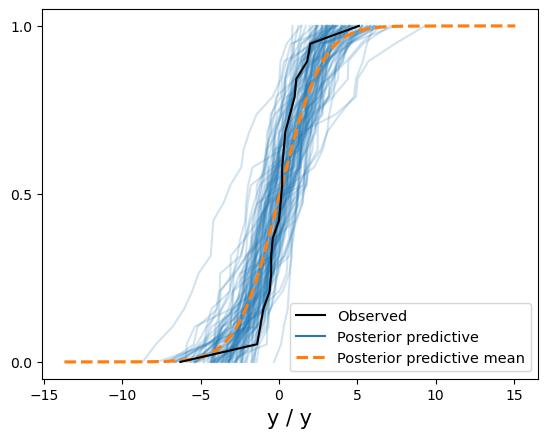

In [6]:
az.plot_ppc(trace, kind="cumulative", num_pp_samples=100)
plt.show()

Doesn't look like our posterior does a good job of fitting the observed data. The mean fits okay, but both tails have some issues because of some extreme values near the endpoints. This plot is just comparing individual ECDFs, though. It's not evaluating the posterior ECDF at the observed $y$ values. 

Plots in general might not be the easiest thing to interpret if we have a lot of datapoints. I wrote the following function to recreate the lecture example.

In [7]:
def evaluate_ecdf(trace: az.InferenceData) -> np.array:
    """Evaluates ECDF at original observed values.

    This function assumes a single set of observed values.

    Args:
        trace: arviz.InferenceData from running a PyMC model.

    Returns:
        A Numpy array of the ECDF evaluation at each original datapoint.
    """
    # get posterior predictive variable name
    ppc_vars = list(trace.posterior_predictive.data_vars)
    assert (
        len(ppc_vars) == 1
    ), "Number of variables in posterior predictive must equal 1."
    y_varname = ppc_vars[0]

    # get original observations
    y_obs = trace.observed_data[y_varname].values
    assert len(y_obs.shape) == 1, "Y-observations shape must be one-dimensional."
    n_obs = y_obs.shape[0]
    y_obs = y_obs.reshape(-1, 1)  # for broadcasting

    # get posterior predictive samples for each y_obs and sample count
    y_samples_per_obs = trace.posterior_predictive[y_varname].stack(
        sample=("chain", "draw")
    )
    assert y_samples_per_obs.shape[0] == n_obs, "Shape assumptions aren't met."
    n_samples = y_samples_per_obs.shape[1]

    # evaluate ECDF at each y_obs and convert to numpy array
    ecdf_values = y_samples_per_obs <= y_obs
    prob = ecdf_values.sum(dim="sample") / n_samples

    return prob.to_numpy()

In [8]:
prob = evaluate_ecdf(trace)

print(prob)
print(np.log(prob / (1 - prob)) ** 2)  # squared logit

[0.4905   0.668375 0.813875 0.304625 0.571    0.393625 0.610375 0.2775
 0.508125 0.41075  0.528375 0.395    0.2455   0.79225  0.53125  0.540125
 0.38525  0.681625 0.986875 0.005   ]
[ 0.00144435  0.49118313  2.17677064  0.68123523  0.08175727  0.18671035
  0.20150114  0.91565089  0.00105644  0.13022411  0.01290998  0.18176809
  1.26058627  1.79169352  0.01566581  0.0258714   0.21839098  0.57950114
 18.66261234 28.01907597]


The last two values are the outliers. I've saved the old version of this code below, you should be able to click to expand it.

In [9]:
# old version
# transforming data so we can broadcast
y_data = xr.DataArray(y, dims=("y_dim_2",))
y_sampled = trace.posterior_predictive["y"]
y_data = y_data.expand_dims(
    {"chain": y_sampled.chain, "draw": y_sampled.draw}, axis=(0, 1)
)

# "cumulative(y_sampled, y_data)", equivalent of cumulative(y[i], y[i]) in BUGS.
cumulative_sum = (y_sampled <= y_data).sum(dim=["chain", "draw"])
probabilities = cumulative_sum / (y_sampled.chain.size * y_sampled.draw.size)

print(probabilities)

# add[i] = pow(logit(cuy[i]),2)
add_probabilities = np.log(probabilities / (1 - probabilities)) ** 2
print(add_probabilities)
print(add_probabilities.sum())

<xarray.DataArray (y_dim_2: 20)>
array([0.4905  , 0.668375, 0.813875, 0.304625, 0.571   , 0.393625,
       0.610375, 0.2775  , 0.508125, 0.41075 , 0.528375, 0.395   ,
       0.2455  , 0.79225 , 0.53125 , 0.540125, 0.38525 , 0.681625,
       0.986875, 0.005   ])
Coordinates:
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
<xarray.DataArray (y_dim_2: 20)>
array([ 0.00144435,  0.49118313,  2.17677064,  0.68123523,  0.08175727,
        0.18671035,  0.20150114,  0.91565089,  0.00105644,  0.13022411,
        0.01290998,  0.18176809,  1.26058627,  1.79169352,  0.01566581,
        0.0258714 ,  0.21839098,  0.57950114, 18.66261234, 28.01907597])
Coordinates:
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
<xarray.DataArray ()>
array(55.63560904)


## Another cool Arviz plot

Arviz has the [```plot_lm```](https://python.arviz.org/en/v0.15.1/api/generated/arviz.plot_lm.html) function as well. It's really nice for visualizing the observed data versus the posterior predictive samples. Let's try it with the single-predictor model from [](../unit7/Unit7-demo-regression.ipynb).

In [10]:
data = pd.read_csv("../data/fat.tsv", sep="\t")

y = data["y"].to_numpy(copy=True)
X = data["X8"].to_numpy(copy=True)

with pm.Model() as m:
    sigma = pm.Exponential("sigma", 0.05)
    beta0 = pm.Normal("intercept", 0, sigma=10)
    beta1 = pm.Normal("slope", 0, sigma=10)

    mu = beta0 + beta1 * X
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(2000)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [y]


Unfortunately, I haven't been able to get this working for a year or two now.

ValueError: x and y must have same first dimension, but have shapes (252,) and (1,)

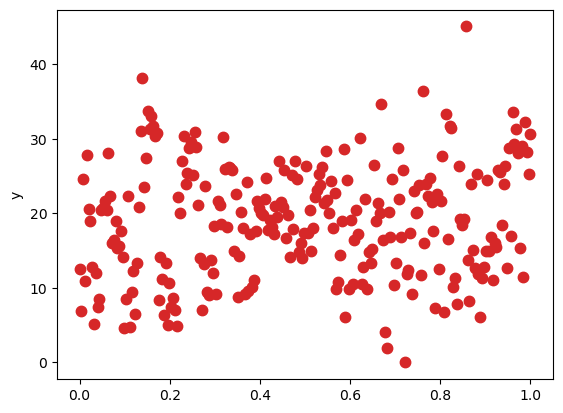

In [11]:
x = xr.DataArray(np.linspace(0, 1, 252))
trace.posterior["y_model"] = trace.posterior["intercept"] + trace.posterior["slope"] * x
az.plot_lm(idata=trace, y="y", x=x)

The below example from the [Arviz docs](https://python.arviz.org/en/v0.16.1/api/generated/arviz.plot_lm.html) still works, but the idata here was generated using PyMC 3. Maybe there's some subtle difference that I'm missing. Let me know if you figure it out!

array([[<Axes: ylabel='y'>]], dtype=object)

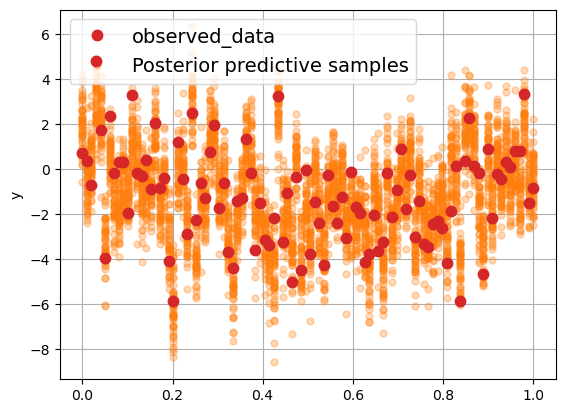

In [12]:
idata = az.load_arviz_data("regression1d")
x = xr.DataArray(np.linspace(0, 1, 100))
idata.posterior["y_model"] = idata.posterior["intercept"] + idata.posterior["slope"] * x
az.plot_lm(idata=idata, y="y", x=x)

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Tue Nov 07 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.17.1

arviz     : 0.16.1
pymc      : 5.9.0
pandas    : 2.1.0
numpy     : 1.25.2
xarray    : 2023.8.0
matplotlib: 3.7.2

